In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import r2_score
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
# Define the neural network
class DiffEqNN(tf.keras.Model):
    def __init__(self):
        super(DiffEqNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense2 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense3 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense4 = tf.keras.layers.Dense(2, kernel_initializer='glorot_uniform')  # Two outputs: u(x) and T(x)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

In [55]:
x1 = np.linspace(0, 1, 225).reshape(-1, 1).astype(np.float32)
x2 = np.linspace(0, 1, 225).reshape(-1, 1).astype(np.float32)
ones = np.linspace(1, 1, 225).reshape(-1, 1).astype(np.float32)
zeros = np.linspace(0, 0, 225).reshape(-1, 1).astype(np.float32)


In [56]:
def du1(model):
    
    x = np.concatenate((ones, x2), axis=1)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        # Compute the Jacobian: du/dx
    jacobian_u = tape.batch_jacobian(u, x)
    
    u1_x1 = jacobian_u[:, 0, 0]  # du1/dx1
    
    return u1_x1
    

In [57]:
# Define the differential equations and loss function
# @tf.function
def loss_fn(model, x):
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        # Compute the Jacobian: du/dx
    jacobian_u = tape.batch_jacobian(u, x)
    
    
    u1_x1 = jacobian_u[:, 0, 0]  # du1/dx1
    
    u1_x2 = jacobian_u[:, 0, 1]  # du1/dx2
    
    u2_x1 = jacobian_u[:, 1, 0]  # du2/dx1
    
    u2_x2 = jacobian_u[:, 1, 1]  # du2/dx2
    
    a = 0.3
    v = a**2
    C = tf.convert_to_tensor([[1/(1-v), a/(1-v), 0],
                              [a/(1-v), 1/(1-v), 0],
                              [0, 0, 0.5/(1+a)]], dtype=tf.float32)
    
    exx = u1_x1
    eyy = u2_x2
    exy = 0.5*(u2_x1 + u1_x2)
    
    # Strain tensor
    ep = tf.stack([exx, eyy, exy], axis=-1)
    
    ep_t = tf.transpose(ep, perm=[1, 0])
    
    sigmat = tf.matmul(C,ep_t)
    sigma = tf.transpose(sigmat)
    
    
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        u1 = sigma
        # Compute the Jacobian: du/dx
    jacobian_s = tape1.batch_jacobian(u1, x)
    
    s11 = jacobian_s[:, 0, 0]
    s22 = jacobian_s[:, 1, 1]
    s12 = jacobian_s[:, 2, 0]
    s21 = jacobian_s[:, 2, 1]


    loss = tf.reduce_mean(tf.square(s11+s21) + tf.square(s12 + s22))
    
    # Boundary conditions
    
    x_train1 = np.concatenate((zeros, x2), axis=1)
    x_train2 = np.concatenate((x1, zeros), axis=1)
    
    u1_0 = model(x_train1)[:, 0:1] 
    u2_0 = model(x_train2)[:, 1:2] 
    
    trac1 = du1(model)
    
    loss = loss+ tf.reduce_mean(tf.square(u1_0)) + tf.reduce_mean(tf.square(u2_0)) + tf.reduce_mean(tf.square(trac1 -1 )) #+ tf.reduce_mean(tf.square(trac2))
    return loss

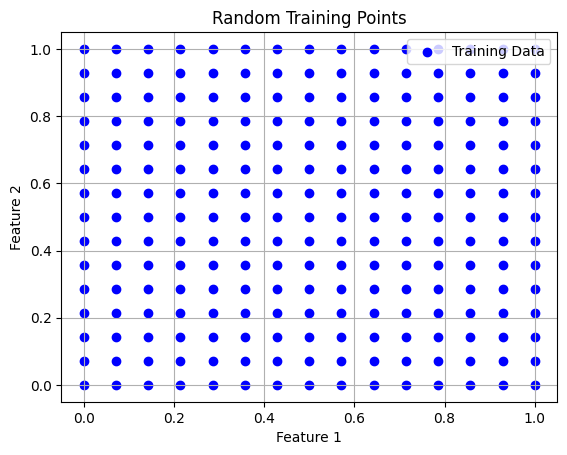

Iteration 0, Loss: 1.0210267305374146
Iteration 100, Loss: 1.2637202416954096e-05
Iteration 200, Loss: 7.78360481490381e-06
Iteration 300, Loss: 6.858134838694241e-06
Iteration 400, Loss: 6.566215233760886e-06
Iteration 500, Loss: 6.312398454610957e-06
Iteration 600, Loss: 6.046513590263203e-06
Iteration 700, Loss: 5.771024007117376e-06
Iteration 800, Loss: 5.490618150361115e-06
Iteration 900, Loss: 5.208659786148928e-06


In [58]:
# Training
model = DiffEqNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

x_train = tf.random.uniform((100, 2), minval=0, maxval=1.0, dtype=tf.float32)  # Training data as Tensor



points_per_dimension = 15
x1_vals = np.linspace(0, 1, points_per_dimension)
x2_vals = np.linspace(0, 1, points_per_dimension)

# Create a meshgrid
x_1, x_2 = np.meshgrid(x1_vals, x2_vals)

# Stack x1 and x2 into a 100x2 array of points
points = np.hstack([x_1.reshape(-1, 1), x_2.reshape(-1, 1)])

# Convert the array into a TensorFlow tensor
tp = tf.convert_to_tensor(points, dtype=tf.float32)


# x_train = np.concatenate((x1, x2), axis=1)
plt.scatter(tp[:, 0], tp[:, 1], c='blue', label='Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Random Training Points')
plt.grid(True)
plt.legend()
plt.show()


losses = []
for i in range(1000):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, tp)
        losses.append(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss}")

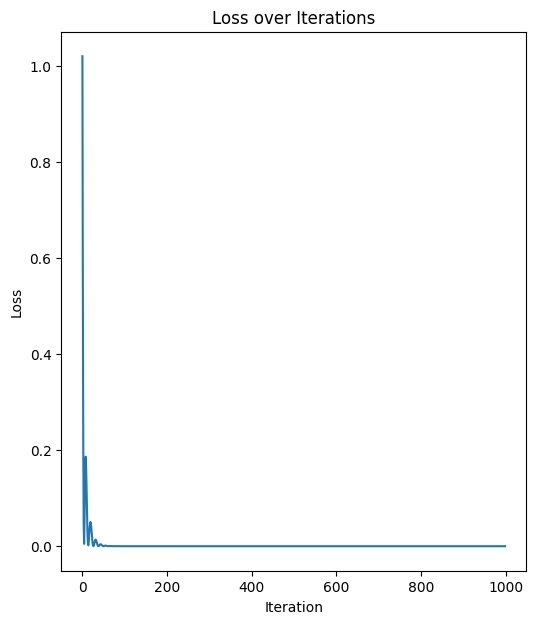

In [59]:
# Plotting the loss over iterations
plt.figure(figsize = (6,7))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


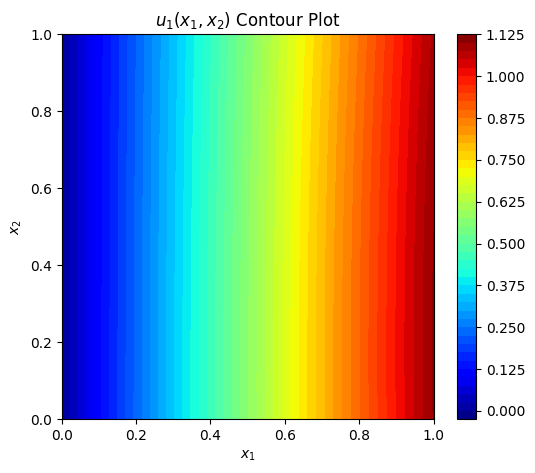

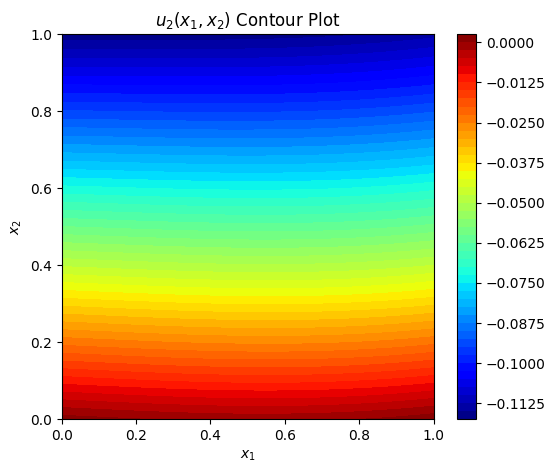

In [60]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the grid for x1 and x2
x1_vals = np.linspace(0, 1, 100)
x2_vals = np.linspace(0, 1, 100)

# Create a meshgrid
x1, x2 = np.meshgrid(x1_vals, x2_vals)

# Flatten and stack x1 and x2 to input into the model
x_test = np.hstack([x1.reshape(-1, 1), x2.reshape(-1, 1)])

# Evaluate the model to get predictions for u1 and u2
u_pred = model.predict(x_test)
u1_pred = u_pred[:, 0].reshape(x1.shape)  # Reshape u1 predictions to match the shape of x1, x2 grid
u2_pred = u_pred[:, 1].reshape(x1.shape)  # Reshape u2 predictions to match the shape of x1, x2 grid

# Plot the contour for u1
plt.figure(figsize=(6, 5))
contour_u1 = plt.contourf(x1, x2, u1_pred, levels=50, cmap='jet')
plt.colorbar(contour_u1)
plt.title(r'$u_1(x_1, x_2)$ Contour Plot')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

# Plot the contour for u2
plt.figure(figsize=(6, 5))
contour_u2 = plt.contourf(x1, x2, u2_pred, levels=50, cmap='jet')
plt.colorbar(contour_u2)
plt.title(r'$u_2(x_1, x_2)$ Contour Plot')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()
